### This is a notebook for comparing predicted segmentation with ground truth segmentations (validation dataset)

In [4]:
from cellpose import utils, dynamics, metrics, plot, io
from numba import jit
from scipy.optimize import linear_sum_assignment
from scipy.ndimage import convolve, mean
import numpy as np
import matplotlib.pyplot as plt

### Loading of *_seg.npy files which contains 

In [5]:
%cd ../validation/

/dtu/blackhole/1d/203261/DL_project/Cell_Segmentation_DL_project/validation


In [6]:
import os, io
current_dir = os.getcwd()

# putting .npy files into a list and sorting the list
ground_truth = [file for file in os.listdir("ground_truth") if file.endswith(".npy")]    
cyto3_pred = [file for file in os.listdir("cyto3_predictions") if file.endswith(".npy")]
fined_tuned_pred = [file for file in os.listdir("fined_tuned_predictions") if file.endswith(".npy")] 
retrained2_pred = [file for file in os.listdir("retrained2_predictions") if file.endswith(".npy")] 

ground_truth_npy = sorted(ground_truth)
cyto3_pred_npy = sorted(cyto3_pred)
fined_tuned_pred_npy = sorted(fined_tuned_pred)
retrained_pred_npy = sorted(retrained2_pred)

#print(ground_truth_npy)
#print(cyto3_pred_npy)

# loading each .npy file into a list and extract only the 'masks' field
groundtruth_masks = [np.load(os.path.join("ground_truth", file), allow_pickle=True).item()['masks'] for file in ground_truth]
predicted_masks = [np.load(os.path.join("cyto3_predictions", file), allow_pickle=True).item()['masks'] for file in cyto3_pred]

print("Number of .npy files loaded:", len(groundtruth_masks))

# accessing the 'masks' directly from the lists
masks_true, mask_pred = groundtruth_masks, predicted_masks

images_names = []
for file in retrained_pred_npy:
    images_names.append(file[:14])
print(images_names)

Number of .npy files loaded: 20
['tile_0003_0023', 'tile_0003_0024', 'tile_0003_0025', 'tile_0003_0027', 'tile_0009_0011', 'tile_0009_0012', 'tile_0027_0010', 'tile_0027_0011', 'tile_0027_0012', 'tile_0027_0013', 'tile_0027_0014', 'tile_0029_0008', 'tile_0029_0009', 'tile_0029_0010', 'tile_0029_0011', 'tile_0029_0012', 'tile_0029_0013', 'tile_0029_0014', 'tile_0029_0015', 'tile_0029_0016']


In [7]:
#!pip install scikit-image
from skimage import io

dat = np.load('ground_truth/tile_0003_0023_seg.npy', allow_pickle=True).item()
img = io.imread('ground_truth/tile_0003_0023.png')
dat.keys()

dict_keys(['outlines', 'colors', 'masks', 'chan_choose', 'filename', 'flows', 'ismanual', 'manual_changes', 'model_path', 'flow_threshold', 'cellprob_threshold', 'normalize_params', 'restore', 'ratio', 'diameter'])

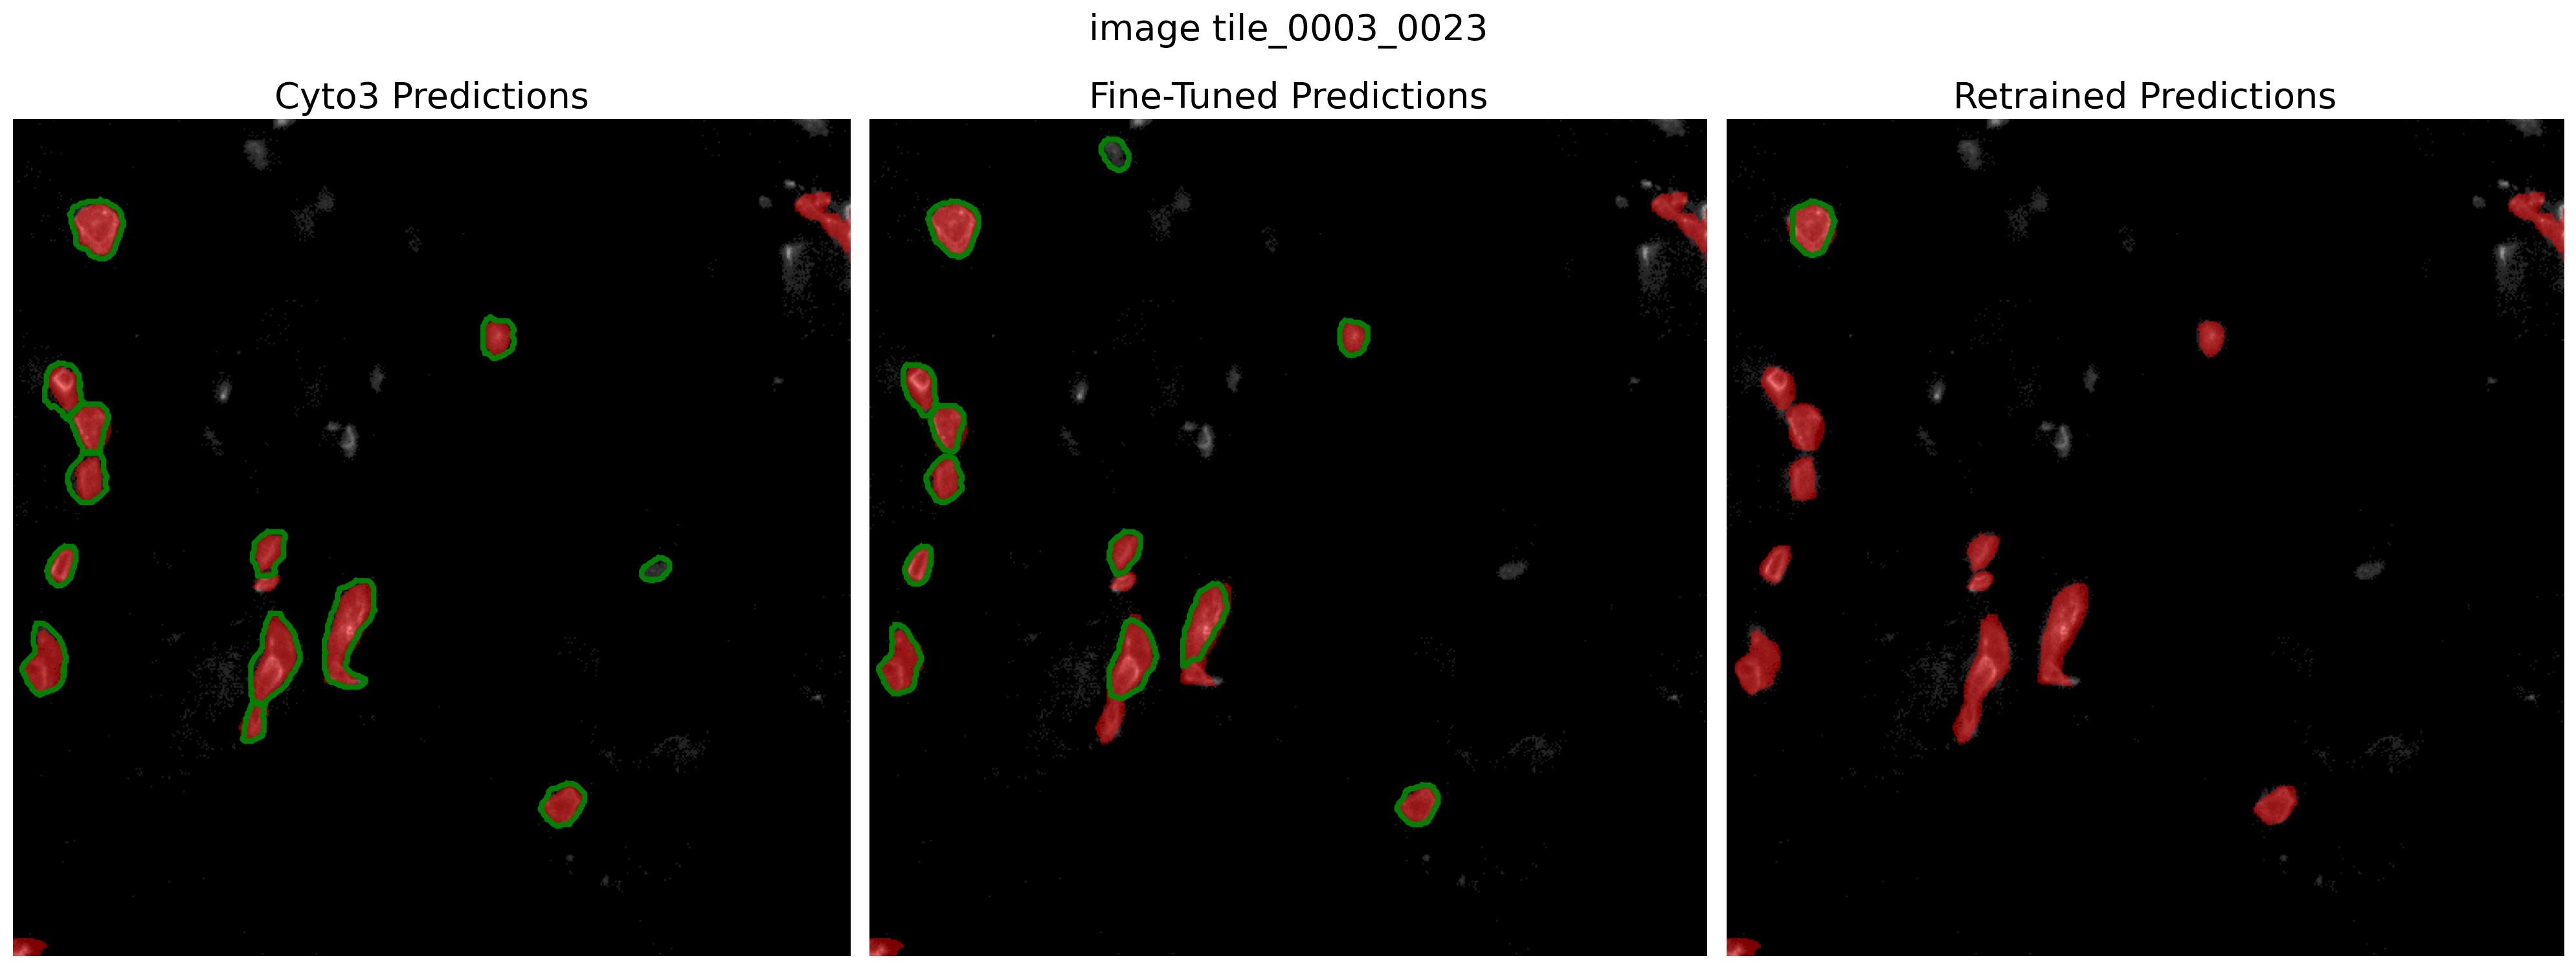

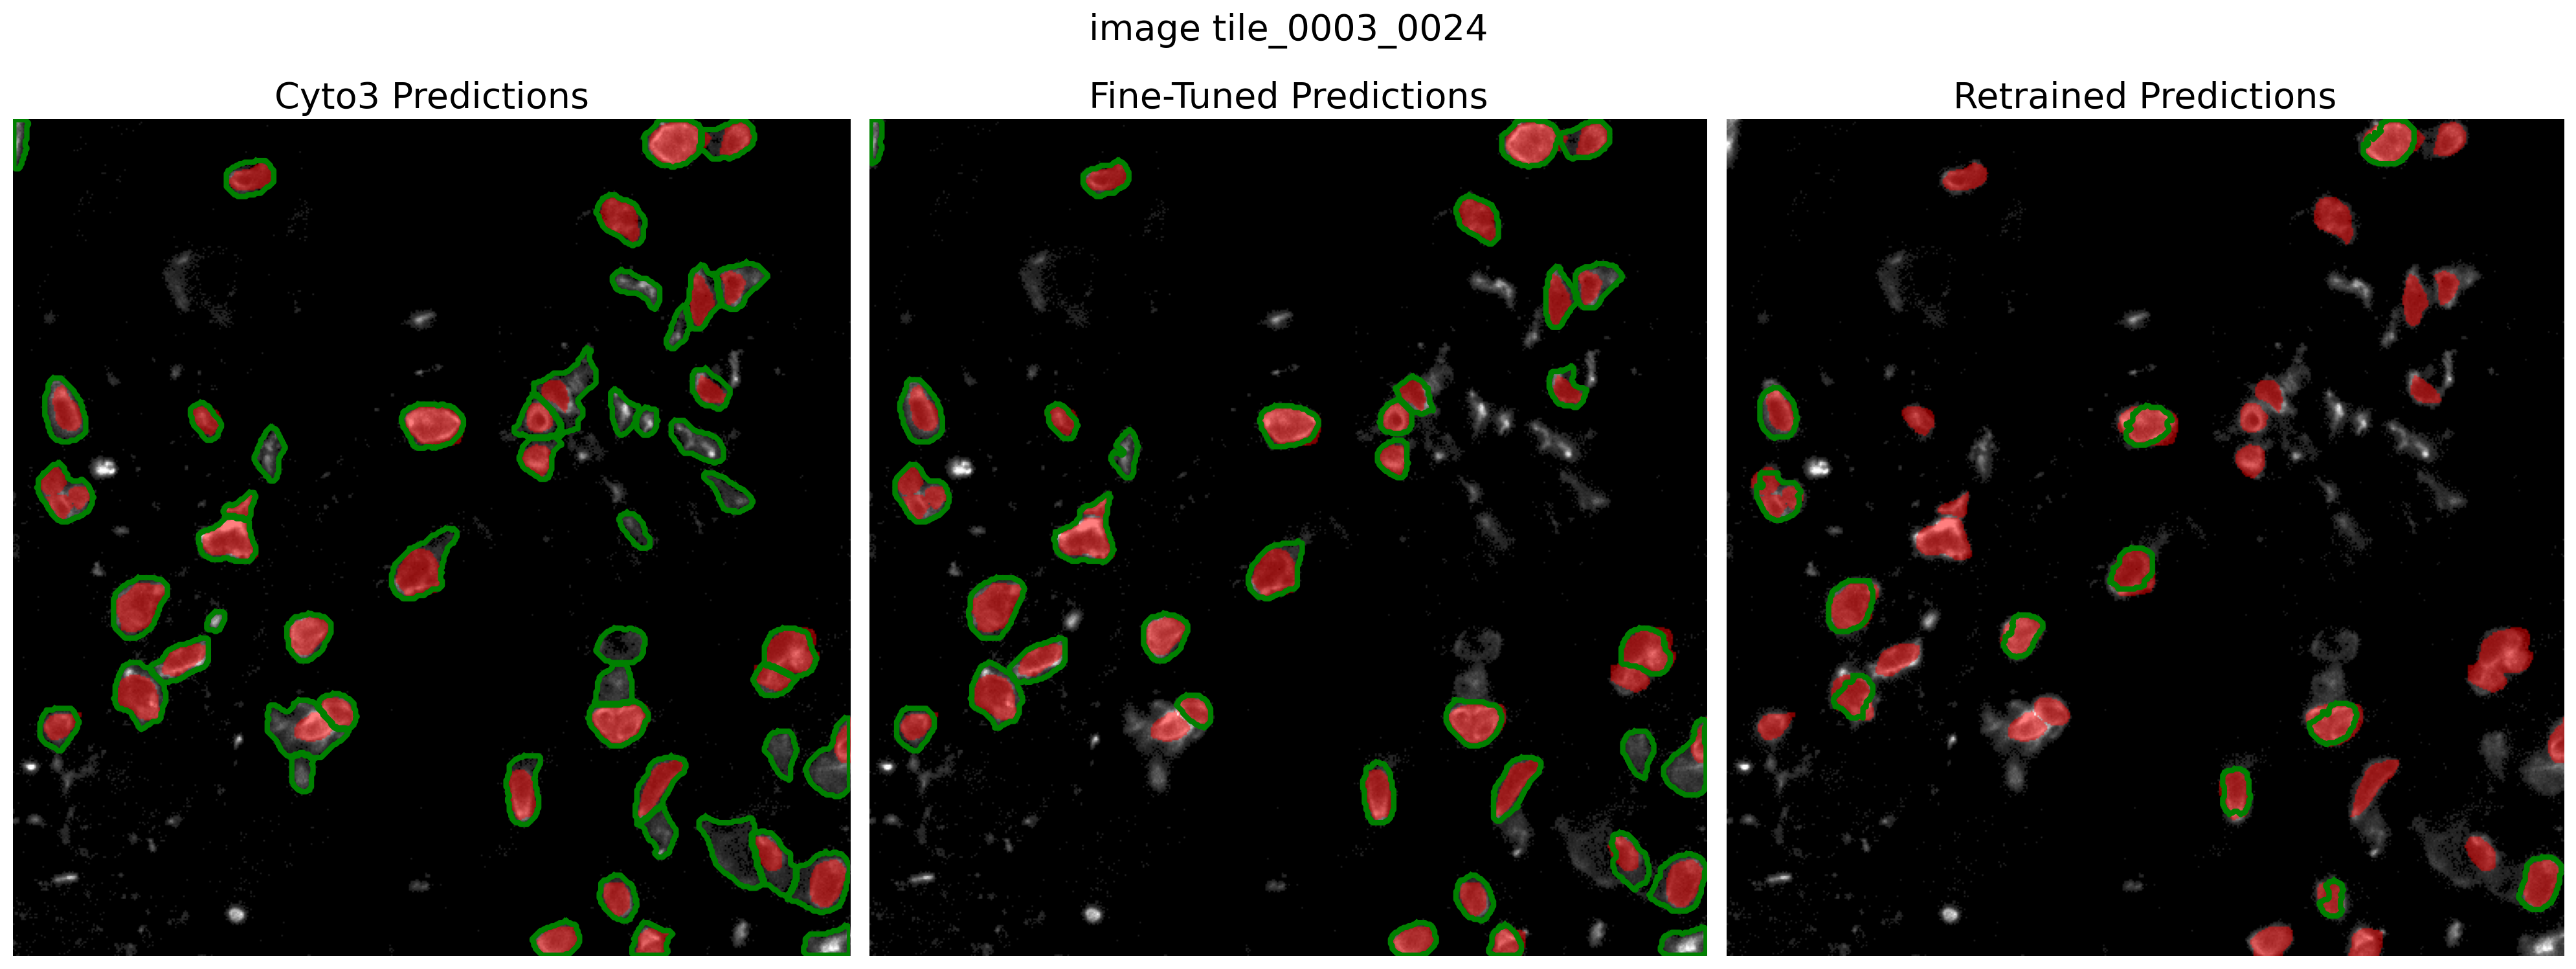

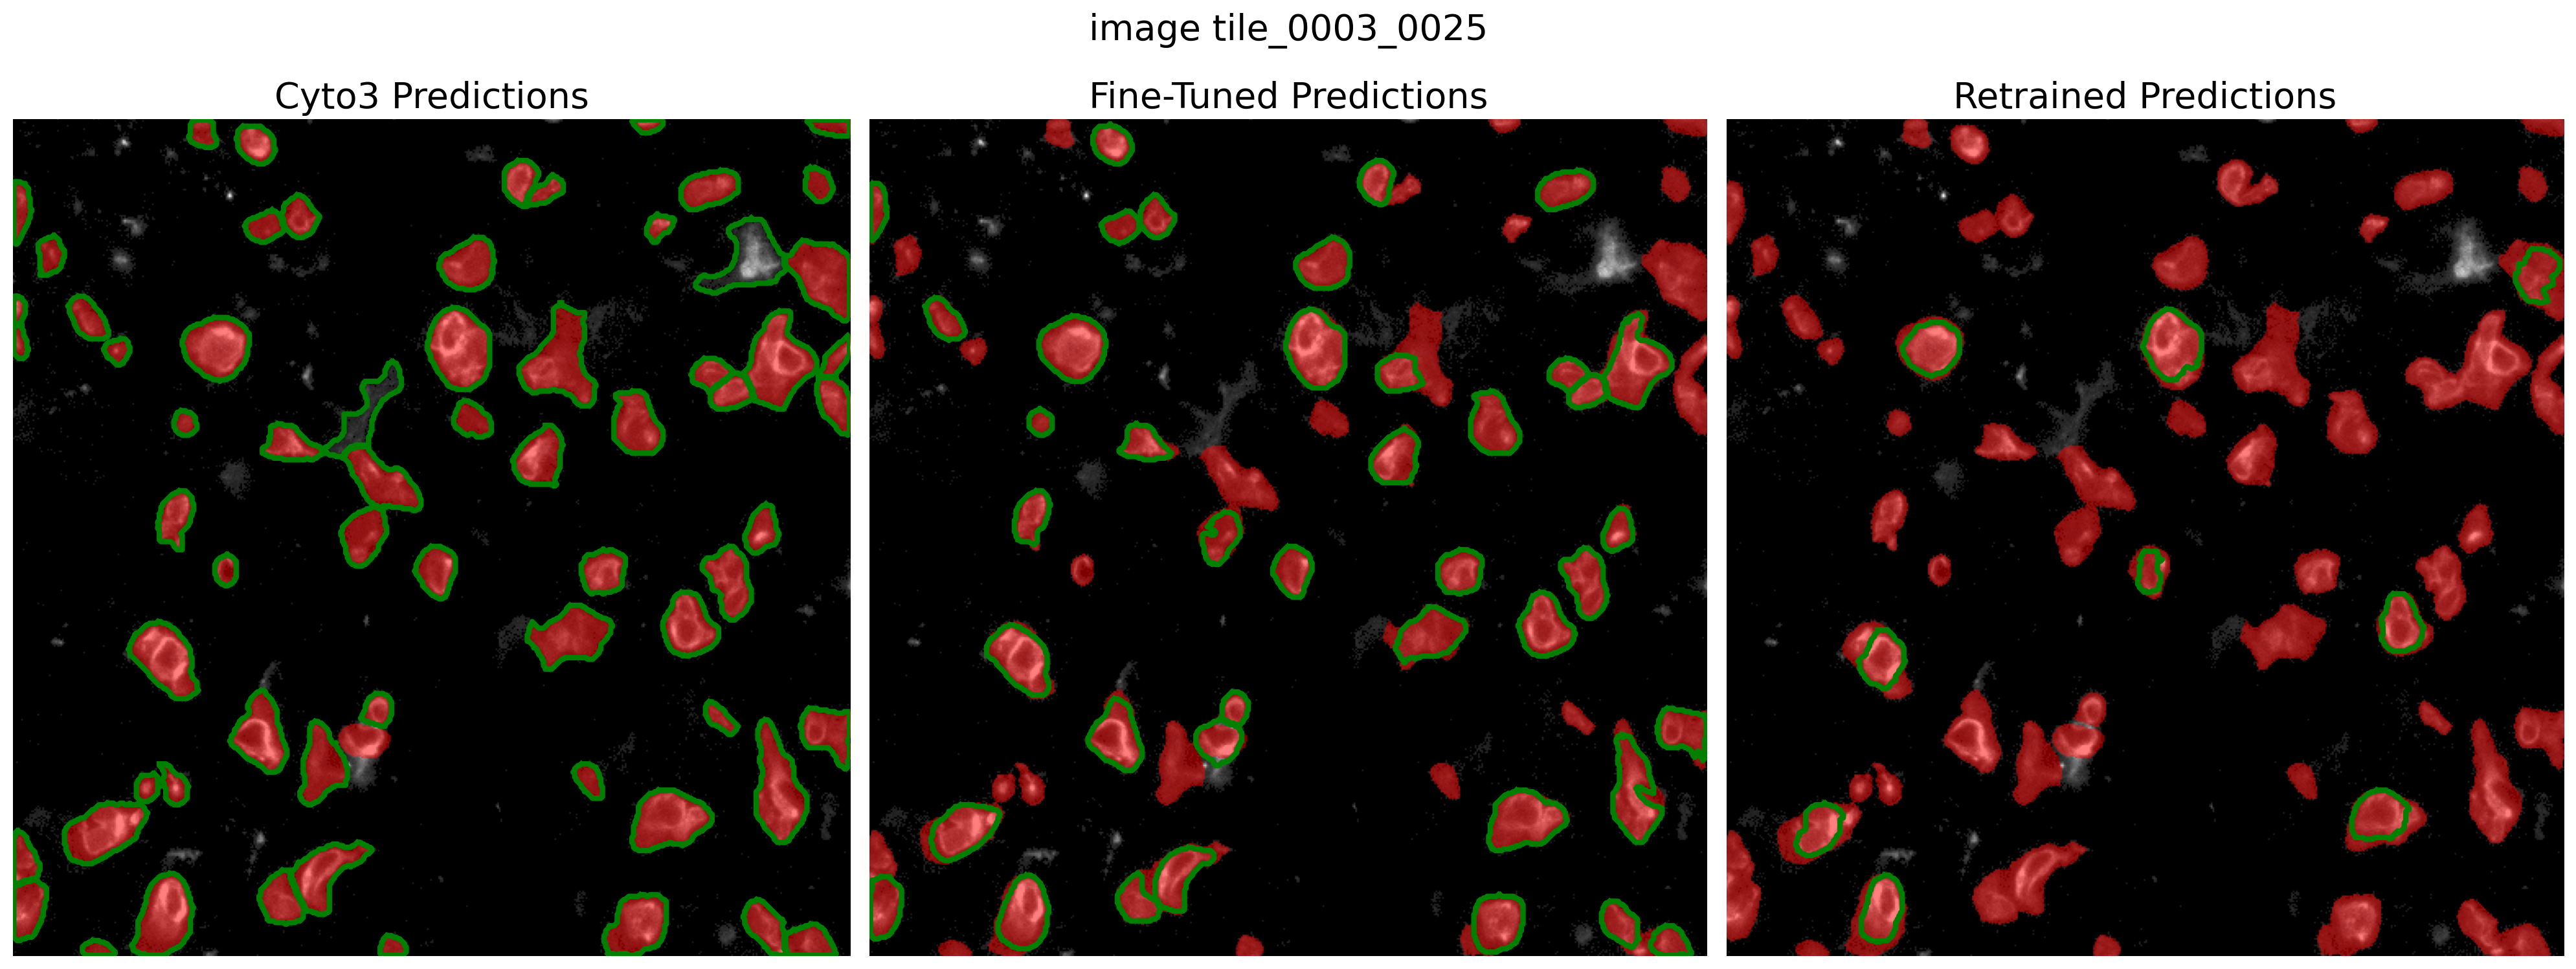

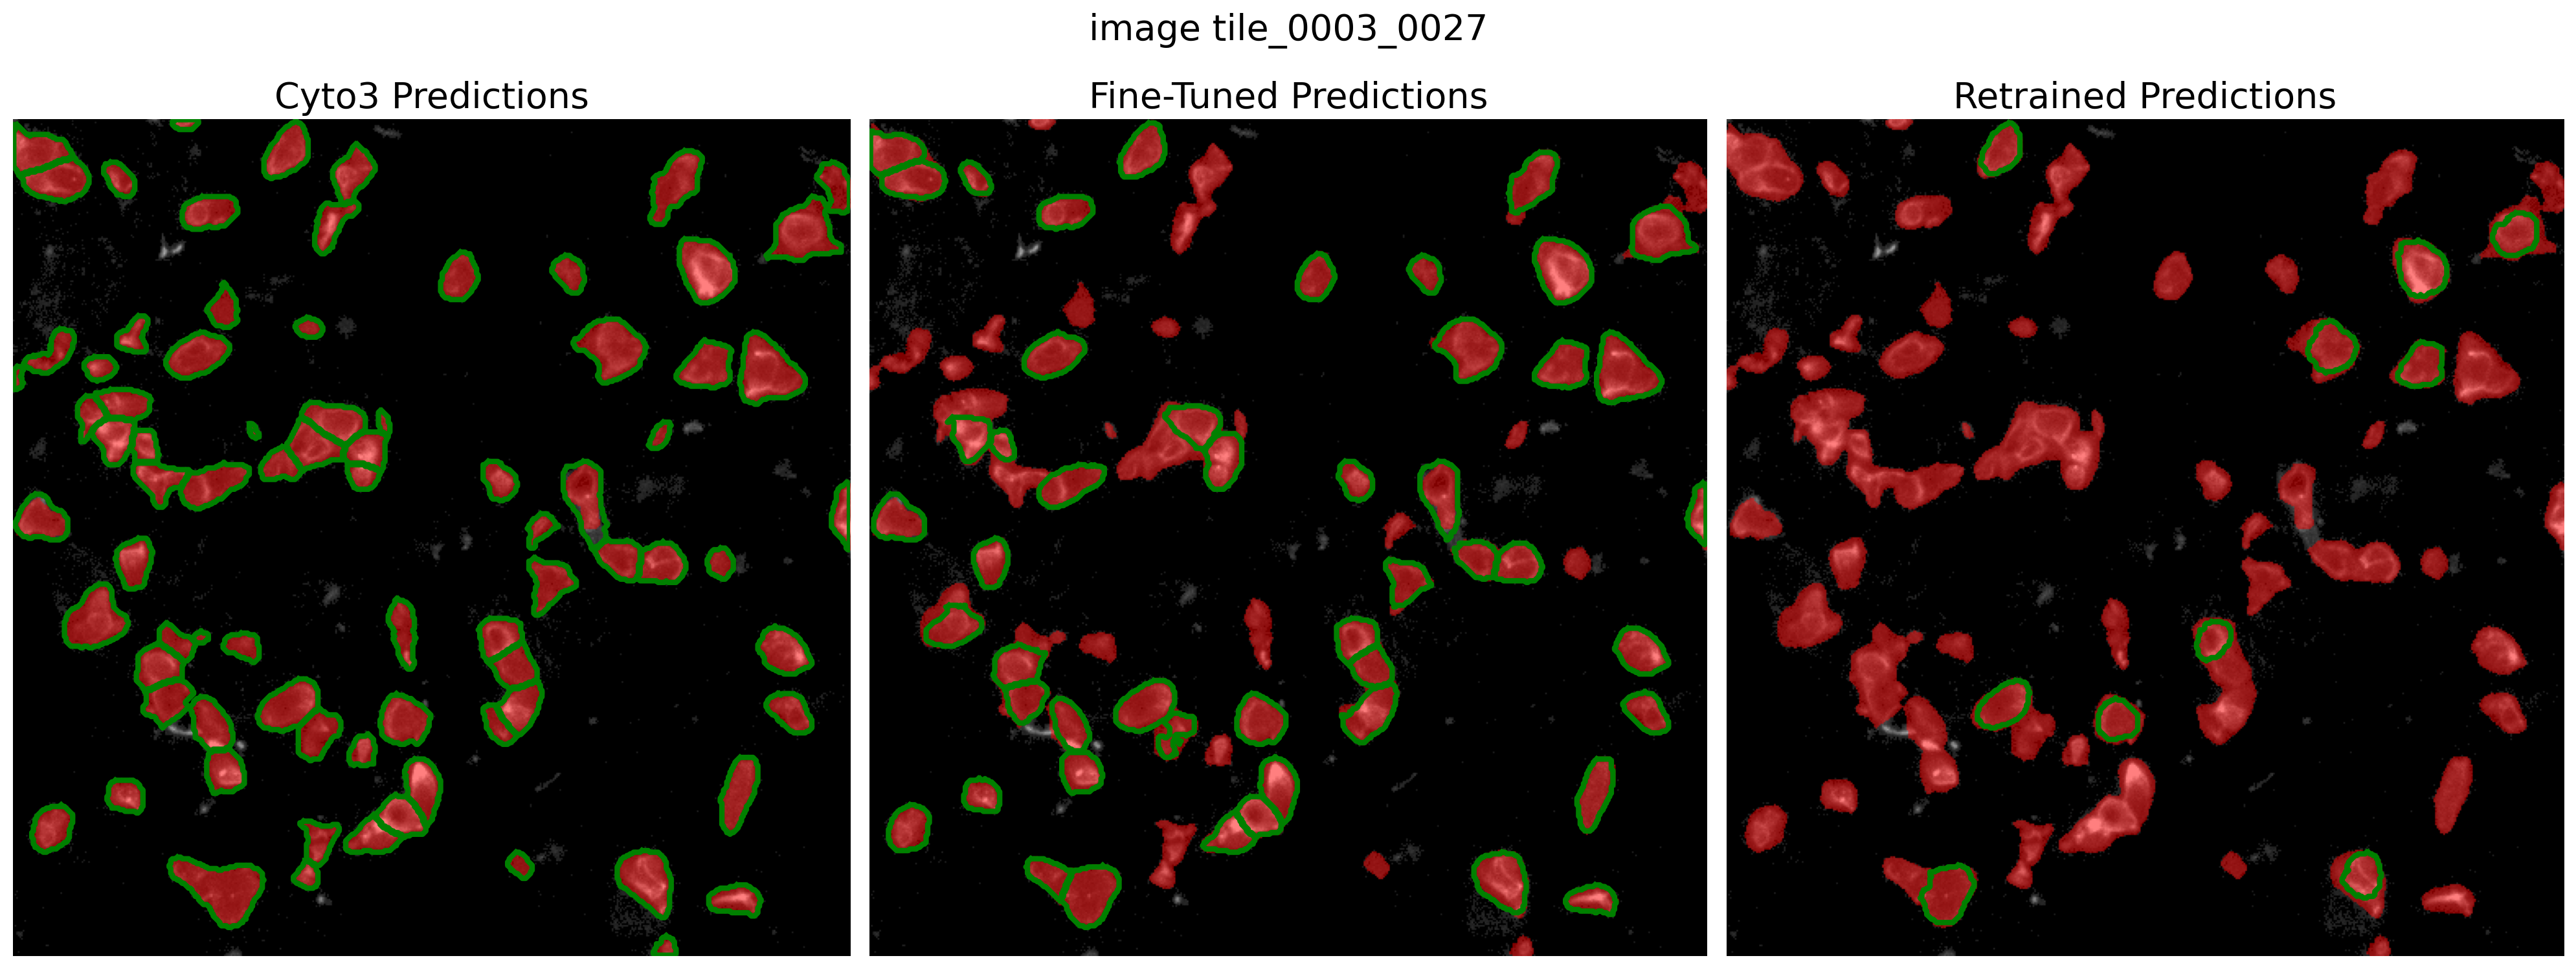

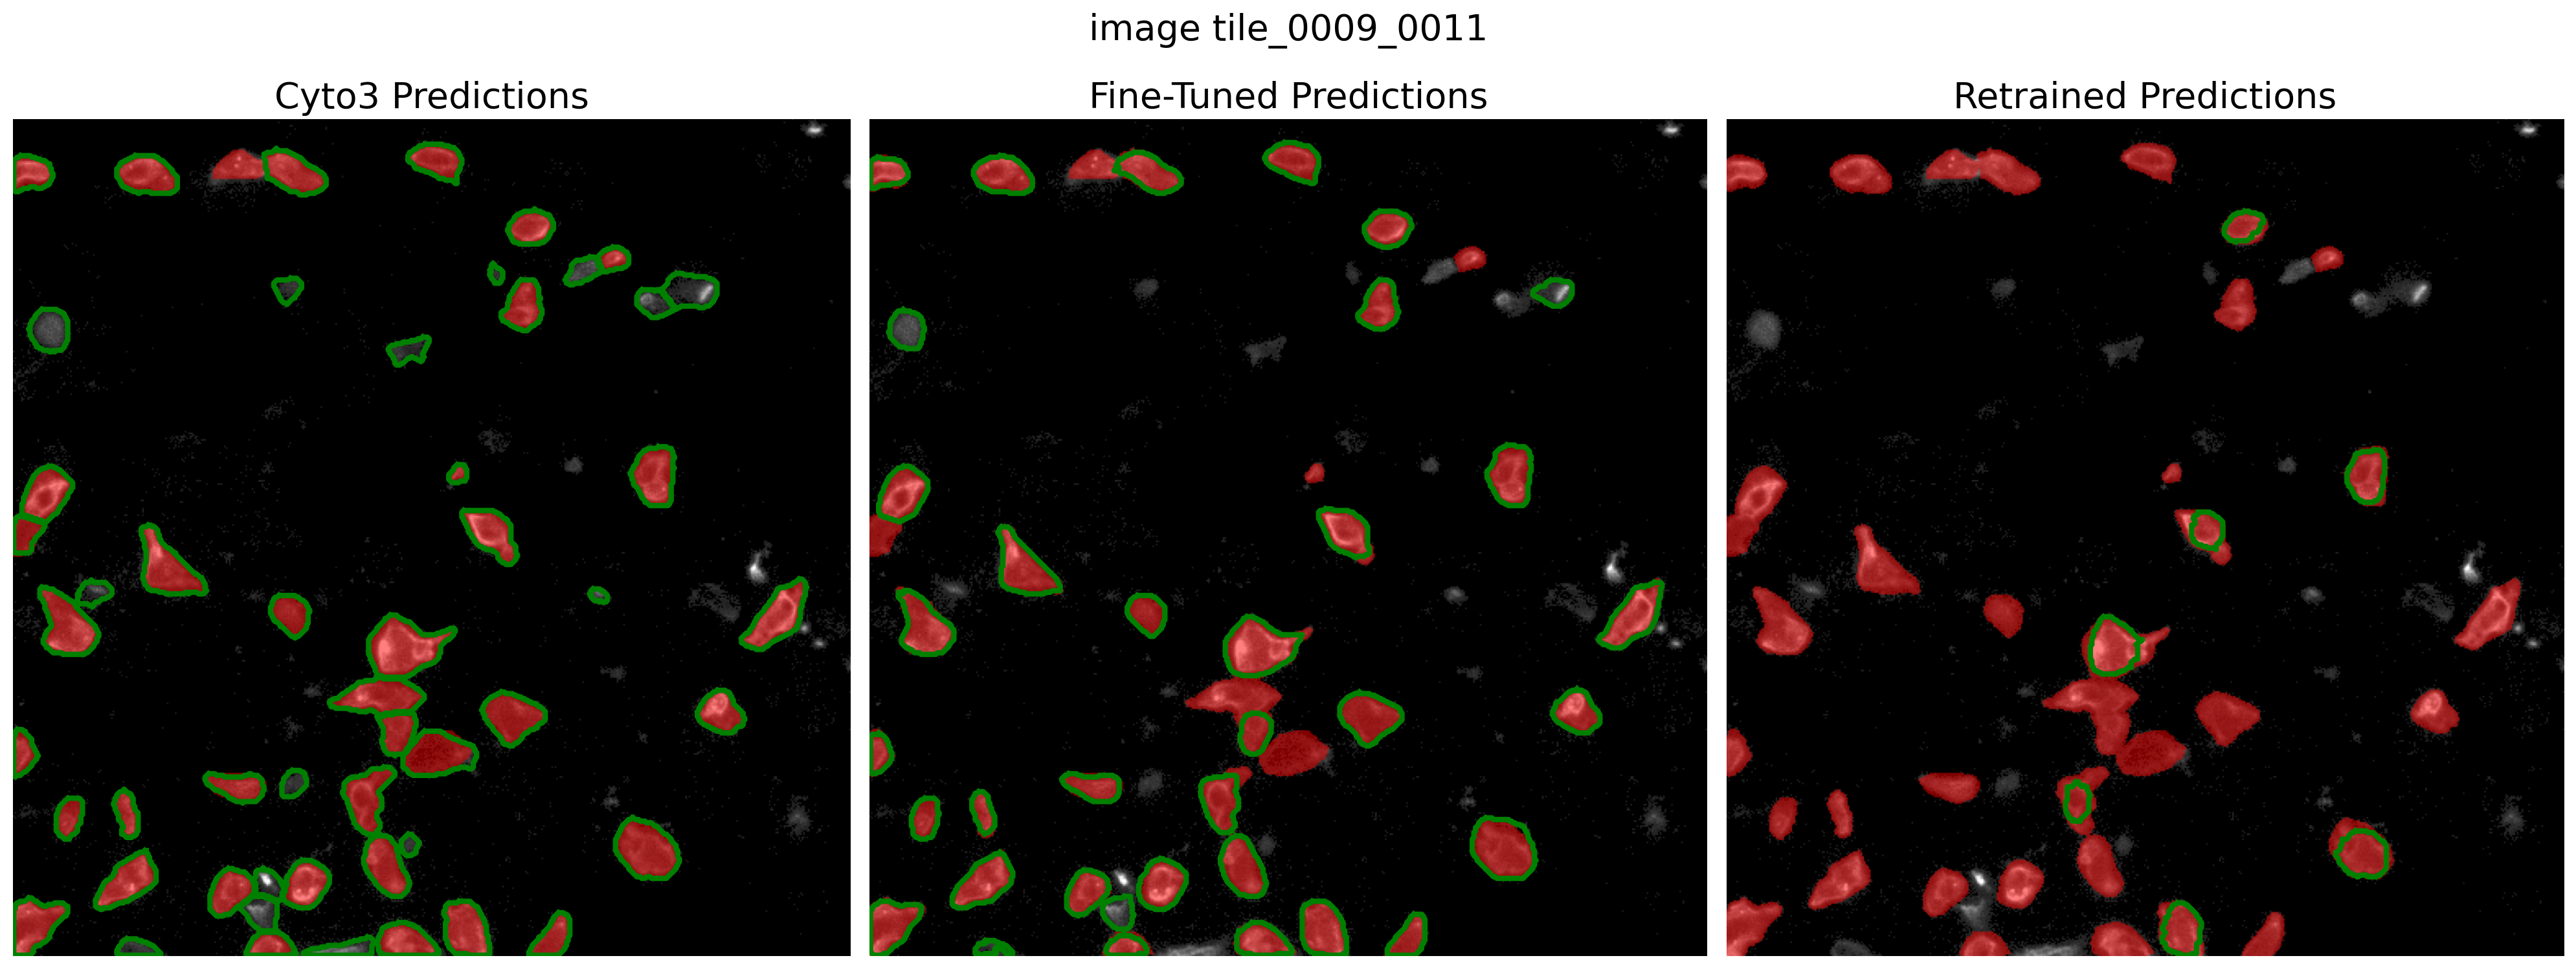

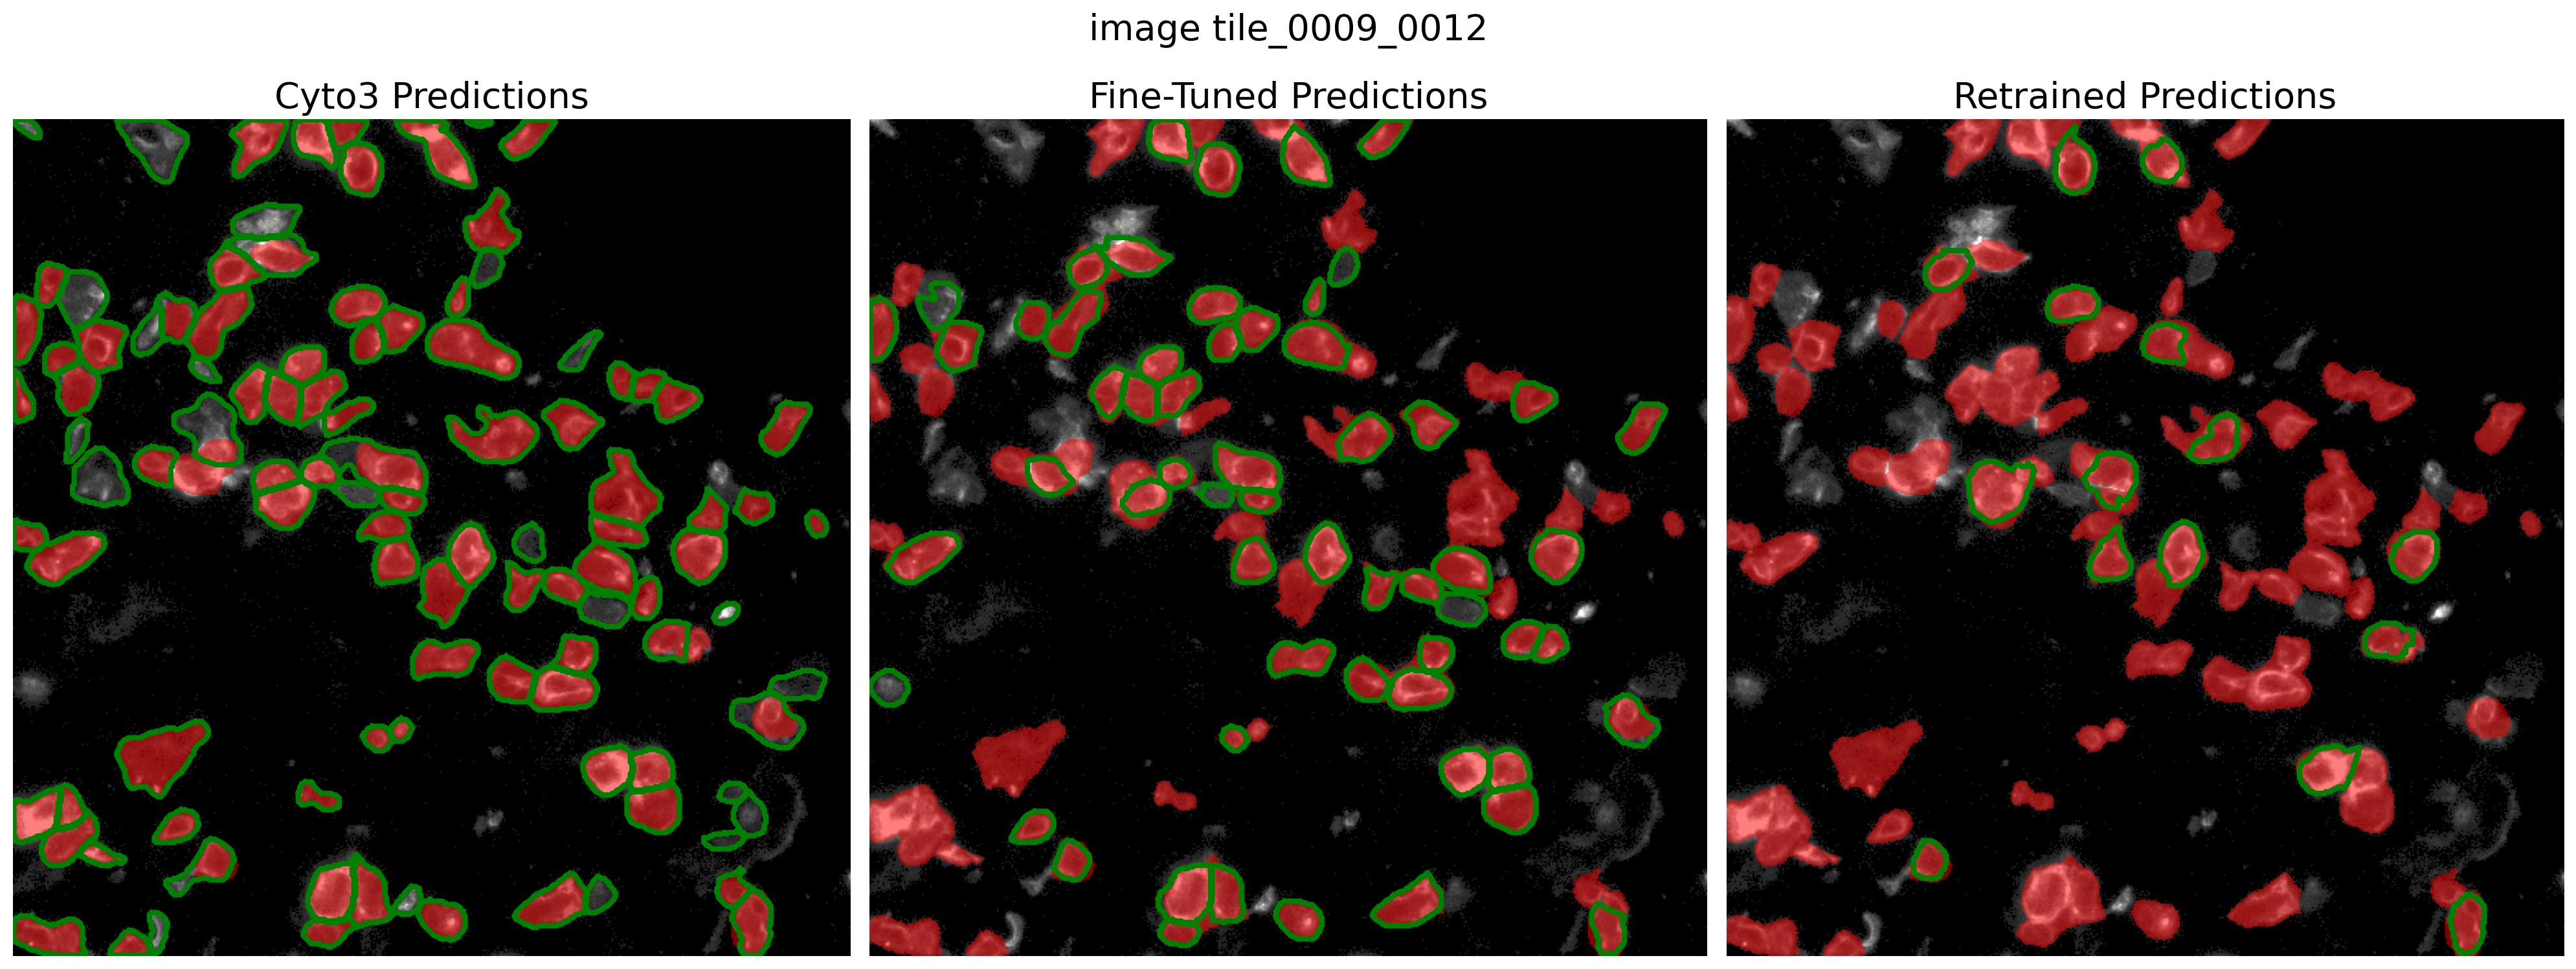

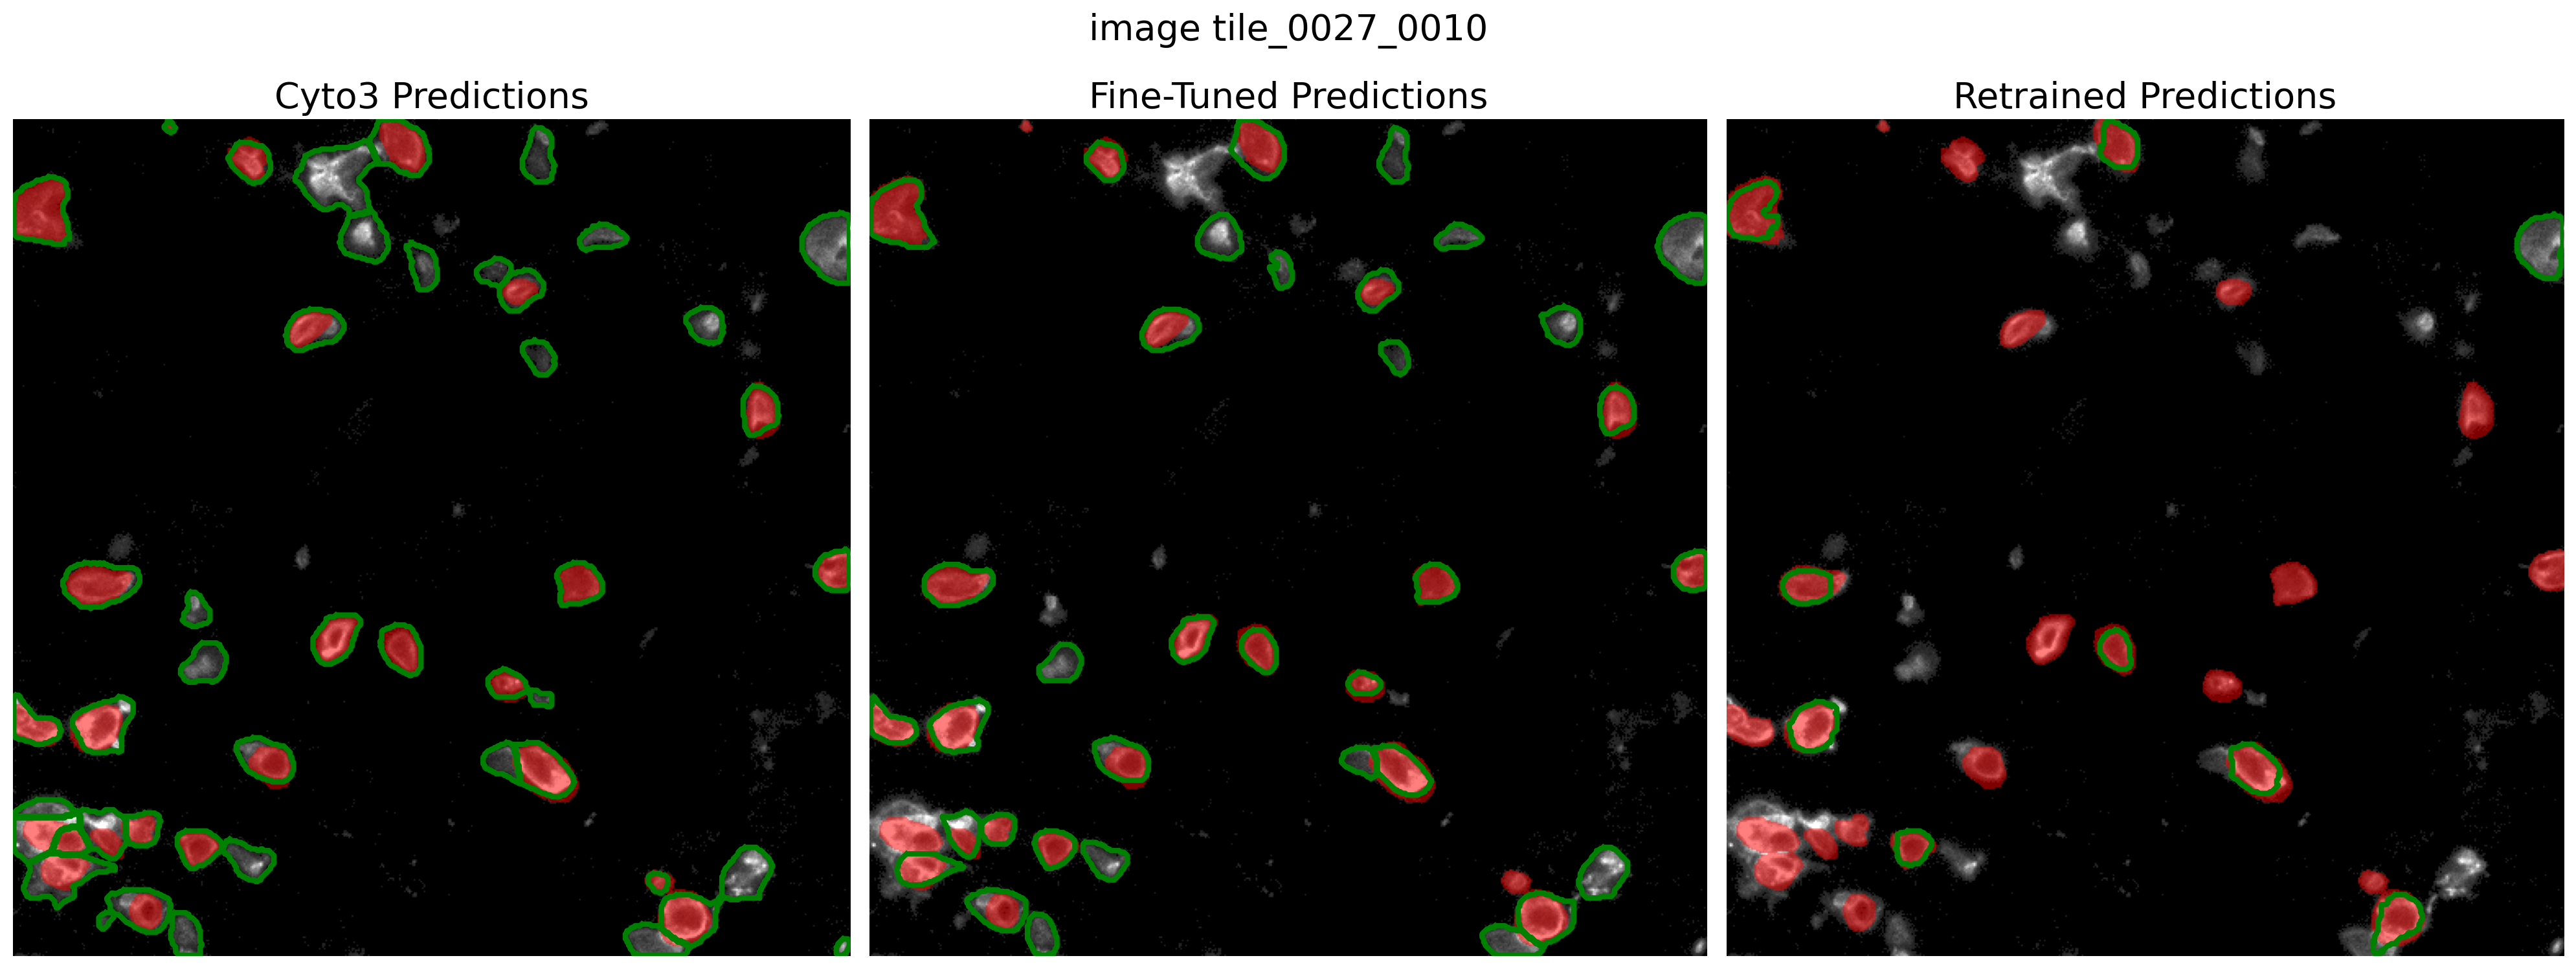

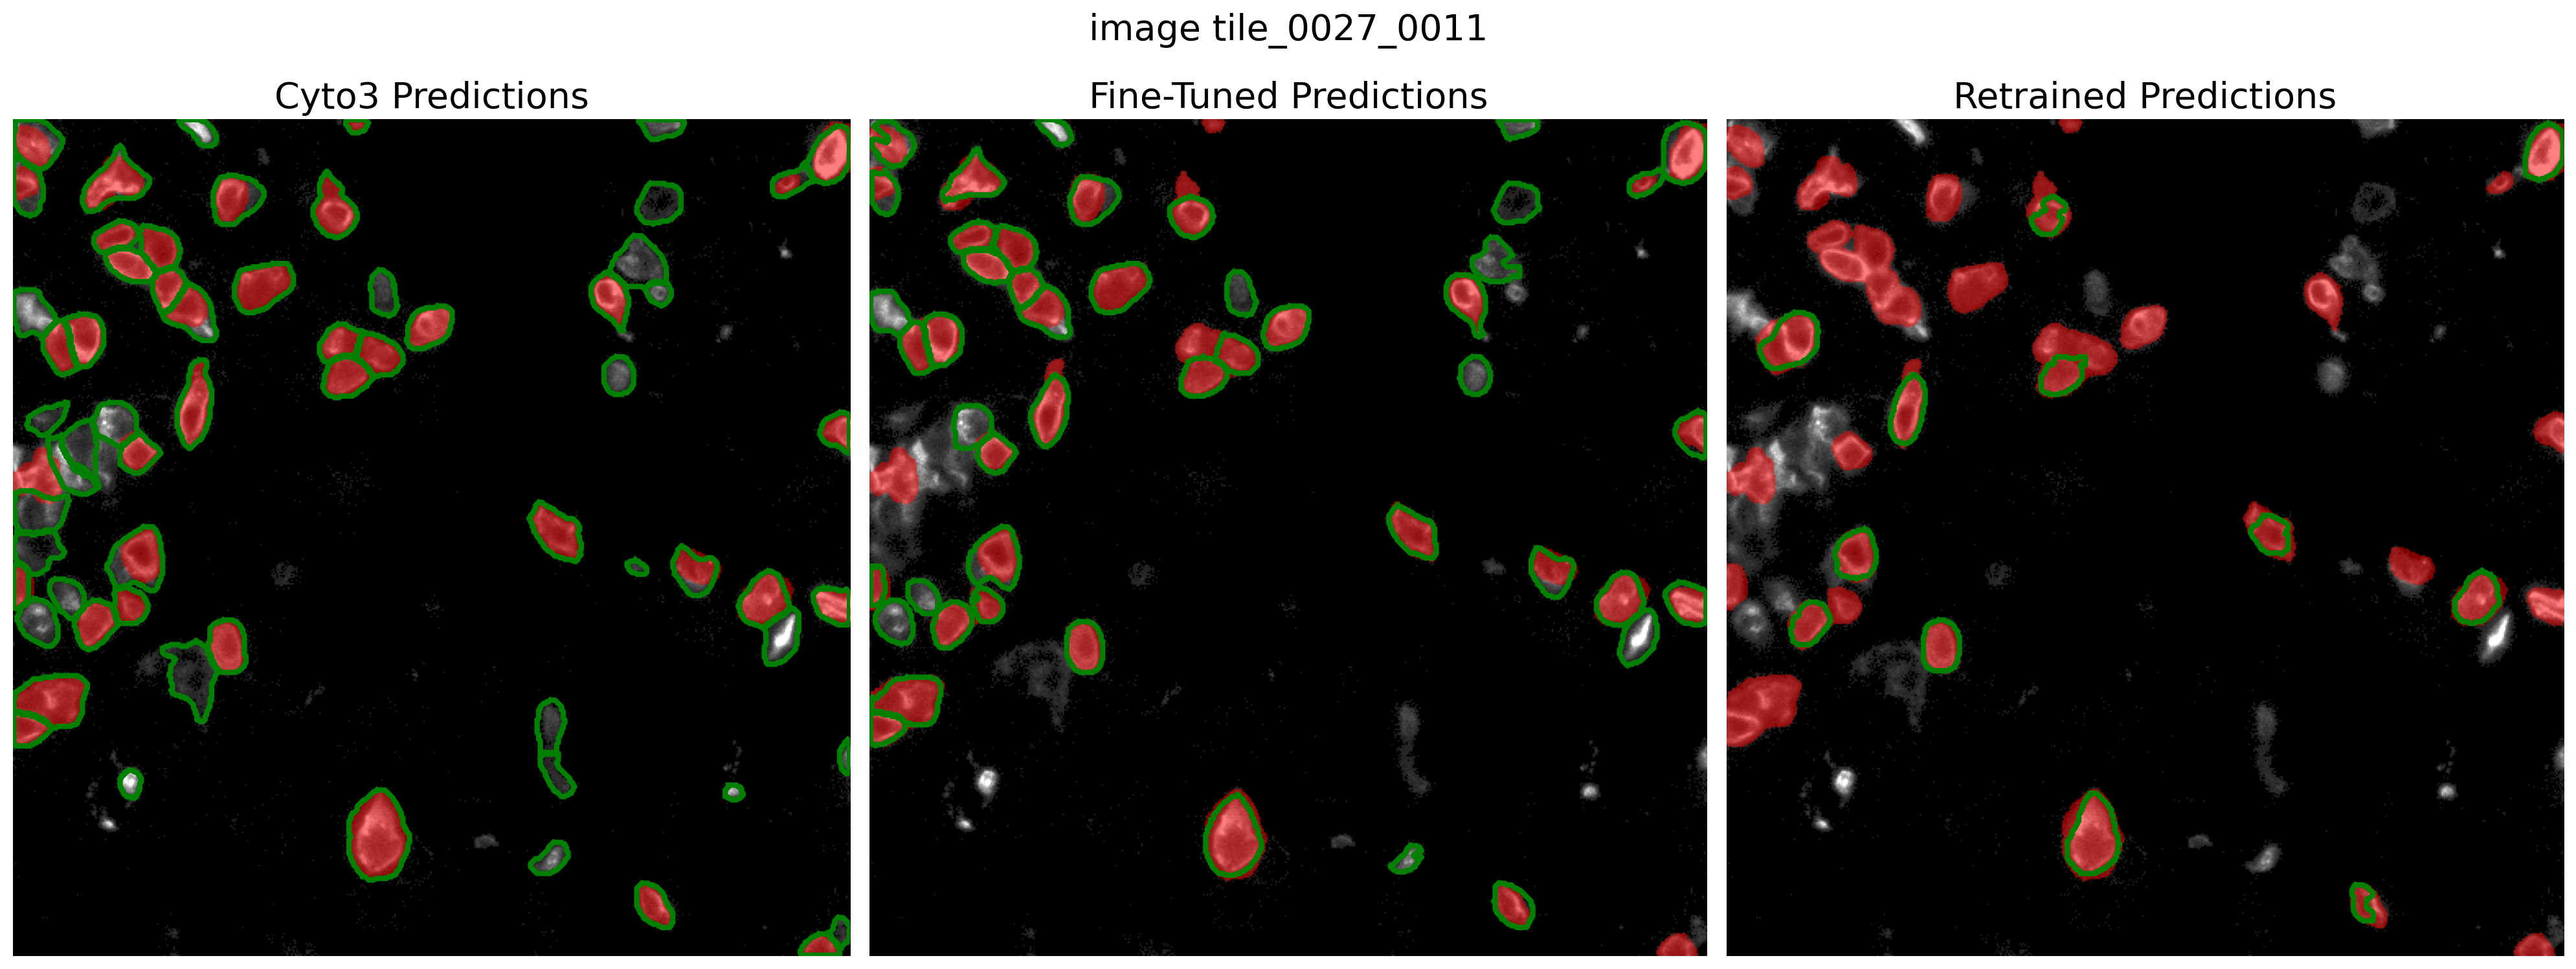

In [ ]:
from IPython.display import display, HTML
import numpy as np
from cellpose import utils
from PIL import Image
import matplotlib.pyplot as plt

# loading images
for tile in images_names:
    dat1 = np.load("ground_truth/" + tile + '_seg.npy', allow_pickle=True).item()
    dat2 = np.load("cyto3_predictions/" + tile + '_seg.npy', allow_pickle=True).item()
    dat3 = np.load("fined_tuned_predictions/" + tile + '_seg.npy', allow_pickle=True).item()
    dat4 = np.load("retrained2_predictions/" + tile + '_seg.npy', allow_pickle=True).item()
    
    img_path = "ground_truth/" + tile + '.png'
    
    # load the PNG image
    image = Image.open(img_path)
    img = np.array(image)
    
    # create an RGB version of the grayscale image
    if len(img.shape) == 2:  # If the image is grayscale
        img_rgb = np.stack([img] * 3, axis=-1)
    else:  # If the image is already RGB
        img_rgb = img.copy()
    
    # set up the figure for the three plots
    plt.figure(figsize=(20, 8), dpi=200)  # Increase figure size and resolution
    
    # list of datasets for predictions
    data_list = [dat2, dat3, dat4]
    titles = ["Cyto3 Predictions", "Fine-Tuned Predictions", "Retrained Predictions"]
    
    # iterate through the datasets (Cyto3, Fine-Tuned, Retrained)
    for i, data in enumerate(data_list, 1):
        # Get the masks for the current dataset
        masks = data['masks']
    
        # create an RGB overlay for the current dataset
        overlay = img_rgb.copy()
        red_mask = np.zeros_like(img_rgb)
        red_mask[..., 0] = 255  # Red channel
    
        # apply the red mask where masks are nonzero
        overlay[dat1['masks'] > 0] = red_mask[dat1['masks'] > 0]
    
        # blend the original image and the red mask (optional transparency)
        alpha = 0.5  # Transparency factor (0 = completely transparent, 1 = completely opaque)
        blended = (img_rgb * (1 - alpha) + overlay * alpha).astype(np.uint8)
    
        # plot the blended image for the current dataset
        #image_title = titles[i - 1] + "image " + str(retrained_pred_npy[i][:14])
        plt.subplot(1, 3, i)
        plt.imshow(blended)
        plt.title(titles[i - 1], fontsize=20)
        plt.axis('off')
    
        # plot the outlines on top of the blended image
        outlines = utils.outlines_list(masks)
        for o in outlines:
            plt.plot(o[:, 0], o[:, 1], color='g', linewidth=3)
            
    plt.suptitle("image " + str(tile[:14]), fontsize=20)
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
    
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
from cellpose import plot, utils, io
import matplotlib.pyplot as plt
import os

# Define paths
ground_truth_dir = "ground_truth"
cyto3_predictions_dir = "cyto3_predictions"
fined_tuned_predictions_dir = "fined_tuned_predictions"
retrained_predictions_dir = "retrained_predictions"

# Get all files in directories
ground_truth_files = [f for f in os.listdir(ground_truth_dir) if f.endswith("_seg.npy")]
cyto3_predictions_files = [f for f in os.listdir(cyto3_predictions_dir) if f.endswith("_seg.npy")]
fined_tuned_predictions_files = [f for f in os.listdir(fined_tuned_predictions_dir) if f.endswith("_seg.npy")]
retrained_predictions_files = [f for f in os.listdir(retrained_predictions_dir) if f.endswith("_seg.npy")]

# Function to plot outlines with a specific color
def plot_outlines(image, masks, ax, title, color, alpha=1.0):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')
    outlines = utils.outlines_list(masks)
    for outline in outlines:
        ax.plot(outline[:, 0], outline[:, 1], color=color, lw=2, alpha=alpha)

# Iterate over each file in the ground truth directory
for file in ground_truth_files:
    # Load data
    gt_data = np.load(os.path.join(ground_truth_dir, file), allow_pickle=True).item()
    img_file = file.replace("_seg.npy", ".png")
    img = io.imread(os.path.join(ground_truth_dir, img_file))
    
    # Load predictions
    cyto3_data = np.load(os.path.join(cyto3_predictions_dir, file), allow_pickle=True).item()
    fined_tuned_data = np.load(os.path.join(fined_tuned_predictions_dir, file), allow_pickle=True).item()
    retrained_data = np.load(os.path.join(retrained_predictions_dir, file), allow_pickle=True).item()
    
    # Create a 1x3 plot for the comparisons
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot ground truth vs cyto3 predictions
    plot_outlines(img, gt_data['masks'], axes[0], f"Ground Truth vs Cyto3: {file}", color='blue', alpha=0.6)
    plot_outlines(img, cyto3_data['masks'], axes[0], "", color='red', alpha=0.6)
    
    # Plot ground truth vs fined-tuned predictions
    plot_outlines(img, gt_data['masks'], axes[1], f"Ground Truth vs Fine-tuned: {file}", color='blue', alpha=0.6)
    plot_outlines(img, fined_tuned_data['masks'], axes[1], "", color='green', alpha=0.6)
    
    # Plot ground truth vs retrained predictions
    plot_outlines(img, gt_data['masks'], axes[2], f"Ground Truth vs Retrained: {file}", color='blue', alpha=0.6)
    plot_outlines(img, retrained_data['masks'], axes[2], "", color='orange', alpha=0.6)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
from cellpose import utils
from PIL import Image
import matplotlib.pyplot as plt

# Paths to the files
tile = "/tile_0003_0023"

dat1 = np.load(groundtruth_files_path + tile + '_seg.npy', allow_pickle=True).item()
dat2 = np.load(predicted_retrained_path + tile + '_seg.npy', allow_pickle=True).item()

img_path = groundtruth_files_path + tile + '.png'

# Load the PNG image
image = Image.open(img_path)
img = np.array(image)

# Get the masks
masks = dat1['masks']


# Create an RGB version of the grayscale image
if len(img.shape) == 2:  # If the image is grayscale
    img_rgb = np.stack([img] * 3, axis=-1)
else:  # If the image is already RGB
    img_rgb = img.copy()

# Create a red overlay for the masks
overlay = img_rgb.copy()
red_mask = np.zeros_like(img_rgb)
red_mask[..., 0] = 255  # Red channel

# Apply the red mask where masks are nonzero
overlay[masks > 0] = red_mask[masks > 0]

# Blend the original image and the red mask (optional transparency)
alpha = 0.5  # Transparency factor (0 = completely transparent, 1 = completely opaque)
blended = (img_rgb * (1 - alpha) + overlay * alpha).astype(np.uint8)

# Plot the image with the red masks overlay
plt.figure(figsize=(10, 10))
plt.title("Image with Red Masks Overlay")
plt.imshow(blended)


# Plot outlines on the original image
outlines = utils.outlines_list(dat2['masks'])
plt.title("Image with Red Outlines")
for o in outlines:
    plt.plot(o[:, 0], o[:, 1], color='b')
plt.axis('off')
plt.show()